In [1]:
from ff_custom_scripts import *
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier, Pool, cv, CatBoostRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
train, test,leaderboard,holdout = load_files(nanvalues='remove')

print(train.shape, test.shape,leaderboard.shape,holdout.shape)

(1172, 1210) (294, 1210) (530, 1210) (1111, 1210)


In [3]:
def get_weights(df,target):
    weights = df[target].value_counts(normalize=True)
    w1 = weights[0].round(2)
    w2 = weights[1].round(2)
    return [w2, w1]

get_weights(train,'eviction')

[0.06, 0.94]

# Model

In [4]:
def run_model(train, test, target='gpa', classifier=False):

    catcols = train.select_dtypes(include=['category']).columns
    train[catcols] = train[catcols].astype(str)
    test[catcols] = test[catcols].astype(str)

    X_train, y_train = prepare_data(train, target)
    X_test, y_test = prepare_data(test, target)

    print(X_train.shape, y_train.shape)

    numerical_features = cols_per_type(X_train, 'Continuous')
    print(f'N. of numerical features: {len(numerical_features)}')
    ordinal_features = cols_per_type(X_train, 'Ordered Categorical')
    binary_features = cols_per_type(X_train, 'Binary')
    print(f'N. of binary features: {len(binary_features)}')
    categorical_features = cols_per_type(X_train, 'Unordered Categorical')
    print(f'N. of categorical features: {len(categorical_features)}')
    print(f'N. of ordinal features: {len(ordinal_features)}')
    
    iter = 20_000

    if classifier:
        # score = 'neg_brier_score'
        catboost = CatBoostClassifier(
            thread_count=-1, cat_features=categorical_features, verbose=0,random_seed=88)
    else:
        
        catboost = CatBoostRegressor(thread_count=-1, cat_features=categorical_features, random_seed=88, 
                                     iterations=iter, early_stopping_rounds=iter*0.1,verbose=10)

    #     score = 'neg_mean_squared_error'

    # param_grid = {
    #     'learning_rate': [0.005, 0.02],
    #     'depth': [4, 8],
    #     'l2_leaf_reg': [2, 3],
    #     'bagging_temperature': [0.5, 1],
    # }

    # model = BayesSearchCV(catboost, param_grid, cv=5, n_jobs=-1, scoring=score, verbose=20,
    #                        n_iter=10).fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=0)
    
    model = catboost.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=0)

    return model


def mse_error(model, data, target='gpa'):
    X, y = prepare_data(data, target)
    y_pred = model.predict(X)
    return mean_squared_error(y, y_pred)

# GPA

In [5]:
gpa_model = run_model(train,test,target='gpa', classifier=False)

(929, 1204) (929,)
N. of numerical features: 106
N. of binary features: 570
N. of categorical features: 114
N. of ordinal features: 414


In [6]:
mse_error(gpa_model, test, target='gpa')

0.39169605871407187

In [7]:
categorical_features = cols_per_type(leaderboard, 'Unordered Categorical')
leaderboard[categorical_features] = leaderboard[categorical_features].astype(str)

mse_error(gpa_model, leaderboard, target='gpa')

0.3825140787606819

# Material Hardship

In [8]:
model_materialHardship = run_model(train,test, target='materialHardship', classifier=False)

(1167, 1204) (1167,)
N. of numerical features: 106
N. of binary features: 570
N. of categorical features: 114
N. of ordinal features: 414


In [9]:
mse_error(model_materialHardship, test, target='materialHardship')

0.019724772285878288

In [10]:
mse_error(model_materialHardship, leaderboard, target='materialHardship')

0.024400836453132256

# Grit


In [11]:
model_grit = run_model(train,test, target='grit', classifier=False)

(1134, 1204) (1134,)
N. of numerical features: 106
N. of binary features: 570
N. of categorical features: 114
N. of ordinal features: 414


In [12]:
mse_error(model_grit, test, target='grit')

0.2149716272725388

In [13]:
mse_error(model_grit, leaderboard, target='grit')

0.24955776354118903

# Eviction

In [14]:
model_eviction = run_model(train,test,target='eviction', classifier=True)

(1167, 1204) (1167,)
N. of numerical features: 106
N. of binary features: 570
N. of categorical features: 114
N. of ordinal features: 414


In [15]:
score_model(model_eviction, target='eviction',test=test, leaderboard=leaderboard, classifier=True, holdout=None)

Scores without threshold adjusment
Test Brier: 0.0514
Test F1: 0.0000
Leaderboard Brier: 0.0566
Number of positive predictions: 0.0
>> Leaderboard F1: 0.0000
Leaderboard Accuracy: 0.9434
Leaderboard Recall: 0.0000


Scores with threshold adjusment


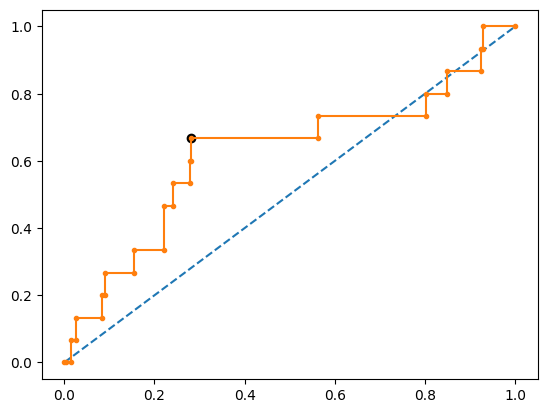

Threshold=0.060, FPR=0.282, TPR=0.667
Test brier: 0.288
Test F1: 0.176
Leaderboard Brier: 0.351
              precision    recall  f1-score   support

         0.0       0.97      0.65      0.78       500
         1.0       0.10      0.67      0.18        30

    accuracy                           0.65       530
   macro avg       0.54      0.66      0.48       530
weighted avg       0.92      0.65      0.74       530

Leaderboard F1: 0.177


In [16]:
score_classifier(model_eviction, target='eviction', holdout=None, test=test,leaderboard=leaderboard)

# jobTraining

In [17]:
model_job = run_model(train,test,target='jobTraining', classifier=True)

(1169, 1204) (1169,)
N. of numerical features: 106
N. of binary features: 570
N. of categorical features: 114
N. of ordinal features: 414


In [18]:
score_model(model_job, target='jobTraining',test=test, leaderboard=leaderboard, classifier=True, holdout=None)

Scores without threshold adjusment
Test Brier: 0.2260
Test F1: 0.0833
Leaderboard Brier: 0.2868
Number of positive predictions: 11.0
>> Leaderboard F1: 0.0380
Leaderboard Accuracy: 0.7132
Leaderboard Recall: 0.0204


Scores with threshold adjusment


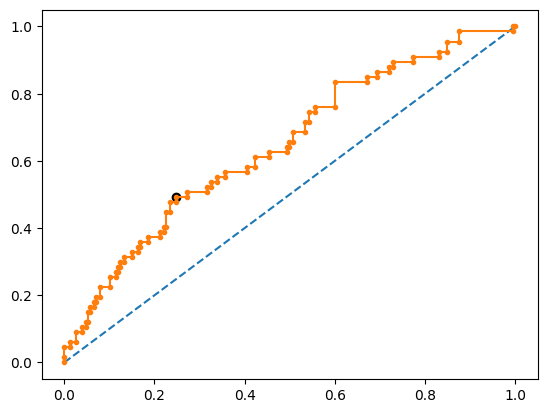

Threshold=0.242, FPR=0.249, TPR=0.493
Test brier: 0.312
Test F1: 0.413
Leaderboard Brier: 0.421
              precision    recall  f1-score   support

         0.0       0.78      0.58      0.67       383
         1.0       0.35      0.58      0.43       147

    accuracy                           0.58       530
   macro avg       0.56      0.58      0.55       530
weighted avg       0.66      0.58      0.60       530

Leaderboard F1: 0.433


In [19]:
score_classifier(model_job, target='jobTraining', holdout=None, test=test,leaderboard=leaderboard)

# Layoff

In [20]:
model_layoff = run_model(train, test, target='layoff', classifier=True)

(1026, 1204) (1026,)
N. of numerical features: 106
N. of binary features: 570
N. of categorical features: 114
N. of ordinal features: 414


In [21]:
score_model(model_layoff, target='layoff',test=test, leaderboard=leaderboard, classifier=True, holdout=None)

Scores without threshold adjusment
Test Brier: 0.1992
Test F1: 0.0000
Leaderboard Brier: 0.2245
Number of positive predictions: 0.0
>> Leaderboard F1: 0.0000
Leaderboard Accuracy: 0.7755
Leaderboard Recall: 0.0000


Scores with threshold adjusment


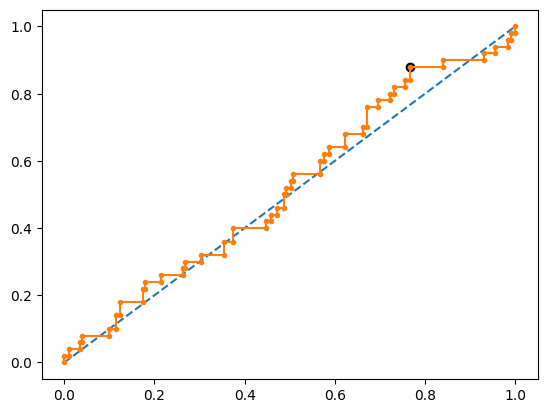

Threshold=0.184, FPR=0.766, TPR=0.880
Test brier: 0.641
Test F1: 0.348
Leaderboard Brier: 0.660
              precision    recall  f1-score   support

         0.0       0.87      0.18      0.29       411
         1.0       0.24      0.91      0.38       119

    accuracy                           0.34       530
   macro avg       0.55      0.54      0.34       530
weighted avg       0.73      0.34      0.31       530

Leaderboard F1: 0.382


In [22]:
score_classifier(model_layoff, target='layoff', holdout=None, test=test,leaderboard=leaderboard)